## Creating an Initial Population

Create an initial population, by first defining the population size and then selecting from the list of recipes.




In [219]:
import json
import pprint
import random
import math
import statistics as stat

# open the saved preprocessed dataset 
with open('data/mochi.json', 'r') as file:
    data = json.load(file)
recipes = data['recipes']

# read additional ingredients for mutations later
with open('data/weird_ingredients_list.json', 'r') as file:
    data = json.load(file)
other_ingredients = data

In [220]:
# categories of ingredients as defined in preprocessing 

categories = {
    "Liquids": ["milk", "almond milk", "coconut", "water"],
    "Other_liquids": ["oil", "juice", "extract", "essence"],
    "Butter": ["butter", "nutella", "peanut butter", "spread"],
    "Sugar": ["sugar"],
    "Flour": ["flour", "starch", "cornstarch", "mochiko"],
    "Pastes": ["paste", "cream"],
    "Solids": ["fruit", "nuts", "chocolate", "raspberries", "strawberries", "banana", "mango", "potato", "corn"],
    "Powder": ["matcha", "powder", "spice"],
    "Bindings": ["egg", "mashed", "applesauce", "puree"],
    "Yeast": ["yeast"],
    "Salt": ["salt"],
    "Icecream": ["ice"],
    "Jam": ["jam", "pudding"],
    "Biscuits": ["biscuits"],
    "Nori": ["nori"],
    "Beans": ["beans"]
}

In [221]:
# make a list of all the available ingredients to add as mutation

all_ingredients = []
for i, recipe in enumerate(recipes):
  all_ingredients.extend(recipe['ingredients'])
# pprint.PrettyPrinter(width=150).pprint(all_ingredients)

for ingredient in all_ingredients:
  amount = ingredient['amount']

## Evaluating Recipes (Fitness Function)

The following function defines how individuals are evaluated:
We chose to evaluate the recipe by calculating the mean of the rating of its ingredients. So, we sum up the rating for each ingredient, and then divide by the total amount of ingredients.
Additionally, we evaluate with some constraints: 
- length of ingredients list of the recipe is between 5-8
- some categories of ingredients have constraints on their presence 
- forbidden ingredients, such as gluten and nuts are penalized 
- if the ratio of flour/liquid-binding is not optimal it will also be penalized

In [222]:
# lists of constraints on the fitness function
presence_egg = ["egg"]
presence_gluten = ["bread flour", "all purpose flour", "all-purpose flour", "nutella", "Biscoff", "biscuits"]
presence_nuts = ["pistachio", "walnuts", "peanut", "hazelnut"]
presence_bakingpwd = ['baking powder']

forbidden = presence_egg + presence_gluten + presence_nuts + presence_bakingpwd
# presence_flour = ["cornstarch", "corn starch", "potato starch", "tapioca starch", "glutinous rice flour", "black sesame flour", "mochiko flour", "sweet rice flour", "glutinous rice flour (mochiko flour)"]

In [223]:

def compute_variables(ingredients):

    mean_rating = []
    forbid = 1
    flour_present = 0
    liquid = 0
    dough = 0
    butter = 0

    for ingredient in ingredients:

        # check current rating 
        mean_rating.append(ingredient['rating'])

        # check if forbidden ingredient is in there, and so make forbid 0
        name = ingredient['ingredient']
        check = list(filter(lambda x: x in name, forbidden))
        if check:
            forbid = 0

        # flower presence 
        if ingredient['category'] == "Flour":
            flour_present += 1

        # categorize ingredients
        if ingredient['category'] == "Liquid":
            liquid += 1
        elif ingredient['category'] in ["Liquids", "Bindings"]:
            dough += 1
        elif ingredient['category'] == "Butter":
            butter += 1

    # check if recipe has essential components, dough presence is either 0 or 1
    dough_presence = 1 if flour_present == 1 and dough >= 1 else 0

    # adjust ingredient constraint based on butter and liquid amounts
    ingredient_constraint = 3 if butter > 1 or liquid > 2 or liquid < 1 else 0
            
    # compute average rating 
    average_rating = stat.mean(mean_rating)

    return average_rating, forbid, dough_presence, ingredient_constraint

def evaluate_recipes(recipes):
    """Evaluate the fitness of each recipe based on rating, amount of ingredients, and presence of ingredients."""

    target_rating_min = 4.7
    target_rating_max = 5.0
    for r in recipes: 
        rating, forbid, dough_presence, ingredient_constraint = compute_variables(r['ingredients'])
        
        length = len(r['ingredients'])
        if length < 5:
            forbid = 0 # no valid mochi, so forbid is 0
            length_penalty = 0 # no length penalty needed
        elif length > 8:
             length_penalty = (length - 8) * 0.5 # small penalty when lenght is higher than 8
        else:
            length_penalty = 0  # No penalty within range

        if rating < target_rating_min:
            rating_penalty = (target_rating_min - rating) * 2  
            scaled_rating = rating - rating_penalty # penalty if rating is below minimum rating
        elif rating <= target_rating_max:
            scaled_rating = random.uniform(target_rating_min, target_rating_max) # pick a random rating between 4.7 and 5 to equalize the odds of choosing them

        # final fitness function to add to each recipe
        r['fitness'] = max(0, scaled_rating - length_penalty - ingredient_constraint)*forbid*dough_presence
        r['rating'] = rating



Evaluate the initial population.

In [224]:
population_size = 20
population = random.choices(recipes, k=population_size)

evaluate_recipes(population)
population = sorted(population, reverse = True, key = lambda r: r['fitness'])
pprint.PrettyPrinter(indent=3, depth=2, width=120).pprint(population)

[  {'fitness': 1.951528047616364, 'ingredients': [...], 'name': 'Ube Mochi', 'rating': 5.0},
   {'fitness': 0, 'ingredients': [...], 'name': 'Mochi Cookies', 'rating': 5.0},
   {'fitness': 0, 'ingredients': [...], 'name': 'Ube Baked Mochi Donuts', 'rating': 3.5},
   {'fitness': 0.0, 'ingredients': [...], 'name': 'Purple Sweet Potato Mochi', 'rating': 4.86},
   {'fitness': 0, 'ingredients': [...], 'name': 'Mango Mochi', 'rating': 3.8},
   {'fitness': 0.0, 'ingredients': [...], 'name': 'Milk Rice Cake', 'rating': 4.75},
   {'fitness': 0.0, 'ingredients': [...], 'name': 'Sweet Potato', 'rating': 5.0},
   {'fitness': 0.0, 'ingredients': [...], 'name': 'Almond Milk', 'rating': 5.0},
   {'fitness': 0, 'ingredients': [...], 'name': 'Savory Sweet Corn Mochi', 'rating': 4.0},
   {'fitness': 0, 'ingredients': [...], 'name': 'Mango Mochi', 'rating': 3.8},
   {'fitness': 0.0, 'ingredients': [...], 'name': 'Blueberry Mochi Ice Cream', 'rating': 5.0},
   {'fitness': 0, 'ingredients': [...], 'name': 

## Selecting recipes

Select recipes based on roulette wheel

In [225]:
def select_recipe(recipes_copy):
  sum_fitness = sum([recipe['fitness'] for recipe in recipes_copy])
  f = random.uniform(0, sum_fitness)
  for recipe in recipes_copy:
    if f < recipe['fitness']:
      return recipe
    f -= recipe['fitness']
  return recipes_copy[-1]

## Crossover and mutations

crossover at random point in each recipe

Mutations include: 
- increasing/decreasing the amount of an ingredient
- substituting with our random ingredient list
- adding or removing ingredients from original set. 

Normalize, get average rating with new ingredient composition and scale amounts 

In [226]:
recipe_number = 1

def crossover_recipes(r1, r2):
  global recipe_number
  p1 = random.randint(0, len(r1['ingredients']))
  p2 = random.randint(0, len(r2['ingredients'])-1)
  r1a = r1['ingredients'][0:p1]
  r2b = r2['ingredients'][p2:]
  r = dict()
  r['name'] = "recipe {}".format(recipe_number)
  recipe_number += 1
  r['ingredients'] = r1a + r2b
  return r

def mutate_recipe(r):
  m = random.randint(0, 3)
  if m == 0:
    i = random.randint(0, len(r['ingredients'])-1)
    r['ingredients'][i] = r['ingredients'][i].copy()
    r['ingredients'][i]['amount'] += math.floor(r['ingredients'][i]['amount'] * 0.1)
    r['ingredients'][i]['amount'] = max(1, r['ingredients'][i]['amount']) # change amount 
  elif m == 1:
    j = random.randint(0, len(r['ingredients'])-1)
    r['ingredients'][j] = r['ingredients'][j].copy()
    r['ingredients'][j] = random.choice(other_ingredients) # substitute with our own ingredient list

  elif m == 2:
    r['ingredients'].append(random.choice(all_ingredients).copy()) # add
  else:
    if len(r['ingredients']) > 1:
      r['ingredients'].remove(random.choice(r['ingredients'])) # remove 

def normalise_recipe(r):

  # average duplicates to get unique list of ingredients
  unique_ingredients = dict()
  for i in r['ingredients']:
    if i['ingredient'] in unique_ingredients:
      n = unique_ingredients[i['ingredient']]
      n['rating'] = (n['rating'] + i['rating']) / 2 # get average rating
      n['amount'] = (n['amount'] + i['amount']) / 2 # get average amount

    else:
      unique_ingredients[i['ingredient']] = i.copy()

  r['ingredients'] = list(unique_ingredients.values())

  sum_amounts = sum([i['amount'] for i in r['ingredients']])
  scale = 500 / sum_amounts
  for i in r['ingredients']:
    i['amount'] = max(1, math.floor(i['amount'] * scale)) # scale amounts

## Generating Recipes

We use the above functions to generate recipes.

In [227]:
def generate_recipes(size, population):
  R = []
  while len(R) < size:
    r1 = select_recipe(population)
    r2 = select_recipe(population)
    r = crossover_recipes(r1, r2)
    mutate_recipe(r)
    normalise_recipe(r)
    R.append(r)
  evaluate_recipes(R)
  return R

## Selecting a New Population

The final function is one that selects a new population given the previous population and the generated recipes.

In [228]:
def select_population(P, R):
  R = sorted(R, reverse = True, key = lambda r: r['fitness'])
  P = P[0:len(P)//2] + R[0:len(R)//2]
  P = sorted(P, reverse = True, key = lambda r: r['fitness'])
  return P

In [229]:
population = random.choices(recipes, k=population_size)
evaluate_recipes(population)
population = sorted(population, reverse = True, key = lambda r: r['fitness'])

max_fitnesses = []
min_fitnesses = []
for i in range(500):
  R = generate_recipes(population_size, population)
  population = select_population(population, R)
  max_fitnesses.append(population[0]['fitness'])
  min_fitnesses.append(population[-1]['fitness'])

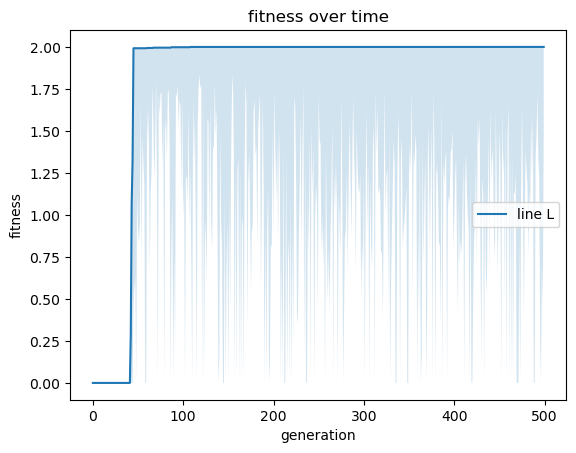

In [230]:
import matplotlib.pyplot as plt

x  = range(500)
plt.plot(x, max_fitnesses, label="line L")
plt.fill_between(x, min_fitnesses, max_fitnesses, alpha=0.2)
plt.plot()

plt.xlabel("generation")
plt.ylabel("fitness")
plt.title("fitness over time")
plt.legend()
plt.show()

In [231]:
len(population[0]['ingredients'])

6

In [232]:
# final recipe
pprint.PrettyPrinter(indent=2, depth=4).pprint(population[0])

{ 'fitness': 1.9999037179044103,
  'ingredients': [ { 'amount': 50,
                     'category': 'Flour',
                     'ingredient': 'potato starch',
                     'rating': 4.75,
                     'unit': 'g'},
                   { 'amount': 116,
                     'category': 'Liquids',
                     'ingredient': 'milk',
                     'rating': 4.7,
                     'unit': 'ml'},
                   { 'amount': 186,
                     'category': 'Solids',
                     'ingredient': 'frozen raspberries, thawed',
                     'rating': 5.0,
                     'unit': 'g'},
                   { 'amount': 1,
                     'category': 'Nori',
                     'ingredient': 'basil',
                     'rating': 4.0,
                     'unit': 'g'},
                   { 'amount': 25,
                     'category': 'Bindings',
                     'ingredient': 'pumpkin puree',
                     'rating': 4.8

# Make ingredient list and instructions

This will write the final fittest recipe to a txt file

In [233]:
recipe = population[0]
ingredients_list = {}

with open(f'recipes_output/output_recipe_{recipe['name']}.txt', 'a') as file: 
    file.write(recipe['name'] + '\n')
    file.write("Rating: " + str(round(recipe['rating'], 2)) + '\n\n') # add rating
    file.write("Ingredients" + '\n\n')
    file.write("- corn starch to dust surface \n") # necessary for all recipes

for ingredient in recipe['ingredients']:
    name = ingredient['ingredient']
    ingredients_list[name] = ingredient['category']
    amount = ingredient['amount']
    unit = ingredient['unit']


    whole = f"- {amount} {unit} {name}" # each ingredient listed 
    with open(f'recipes_output/output_recipe_{recipe['name']}.txt', 'a') as file: 
        file.write(whole + '\n')
        
with open(f'recipes_output/output_recipe_{recipe['name']}.txt', 'a') as file: 
    file.write('\n' + "Instructions")

In [234]:
# categorize ingredients for instructions format 
non_flour_ingredients = []
flour_ingredient = ""
bind_ingredient = ""
solids = []
for ingredient, category in ingredients_list.items():
    if category == 'Flour':
        flour_ingredient = ingredient
    elif category == "Liquids" or category == "Bindings":
        if "extract" not in ingredient:
            bind_ingredient = ingredient
    elif category == "Solids":
        solids.append(ingredient)
    else: 
        non_flour_ingredients.append(ingredient)

# add steps for uncooked solid ingredients
steps = []
for ingredient in solids:
    step = f"If the {ingredient} requires cooking, cook it first, then blend or mash into a puree"
    if step is not None:
        steps.append(step)

formatted_steps = "\n".join(f"{step}" for step in steps)

# Recept template
recipe_template = f"""
1. Prepare the ingredients (if necessary):
{formatted_steps}

2. Prepare the mochi dough:

In a microwave-safe bowl, mix the {flour_ingredient} with the {bind_ingredient} and ingredients of your choice from the ingredients list.
Microwave the combined dough for 90 to 120 seconds.
Stir the mochi mixture so the cooked and uncooked parts are evenly mixed.
Microwave again for 1 minute until the dough is slightly translucent and glossy.

3. Prepare the mochi filling:

In a small bowl, mix the remaining ingredients.
Portion out 8 scoops of filling, using a tablespoon or a cookie scoop, and set aside. If the filling is containing ice cream, set aside in the fridge. 

Making the mochi:

Drop the hot mochi dough onto a surface floured with corn starch.
Use a rolling pin or your hands to flatten it into a sheet.
Cut the dough into 8 pieces using a dough cutter or scissors.
Place a scoop of prepared filling on each piece and wrap the mochi dough around the filling.
Enjoy!
""" 

# Save generated recipe
with open(f'recipes_output/output_recipe_{recipe['name']}.txt', 'a') as file: 
    file.write('\n' + recipe_template)